In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.animation as animation

from torch.utils.data import Dataset
# import binvox
import os
import json
import trimesh
import skimage
import random
# from mesh_to_sdf import mesh_to_voxels, sample_sdf_near_surface, scale_to_unit_sphere
import mesh_to_sdf
import pyrender
import numpy as np
import matplotlib.pyplot as plt
import io
from deep_sdf import utils, metrics, plotting, workspace, mesh
import math
import pandas as pd
import pytorch3d
import sklearn
from sklearn.manifold import TSNE
import torch
import matplotlib
import copy
import shlex

import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

/home/wulff/anaconda3/envs/deep3dcomp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
plotting.plot_manifold_tsne("../../shared/deepsdfcomp/searches/num_shapes_search/all_shapes_batch_size_128/")


<=== Reading net exps ===>
Extracting num_params=37111 width=96 depth=3 latent=200: CD_mean=0.000401 CD_median=0.000107 num_shapes=456
    -> Eval on train set: CD_mean=0.000253 CD_median=0.000095 num_shapes=500
Extracting num_params=74004 width=128 depth=4 latent=200: CD_mean=0.000242 CD_median=0.000084 num_shapes=456
    -> Eval on train set: CD_mean=0.000216 CD_median=0.000071 num_shapes=500
Extracting num_params=258934 width=192 depth=6 latent=200: CD_mean=0.000218 CD_median=0.000047 num_shapes=456
    -> Eval on train set: CD_mean=0.000119 CD_median=0.000036 num_shapes=500
Extracting num_params=557616 width=256 depth=8 latent=200: CD_mean=0.000257 CD_median=0.000045 num_shapes=456
    -> Eval on train set: CD_mean=0.000141 CD_median=0.000034 num_shapes=500
Extracting num_params=1537644 width=384 depth=12 latent=200: CD_mean=0.000268 CD_median=0.000042 num_shapes=456
    -> Eval on train set: CD_mean=0.000063 CD_median=0.000022 num_shapes=500
Extracting num_params=148180 width=192

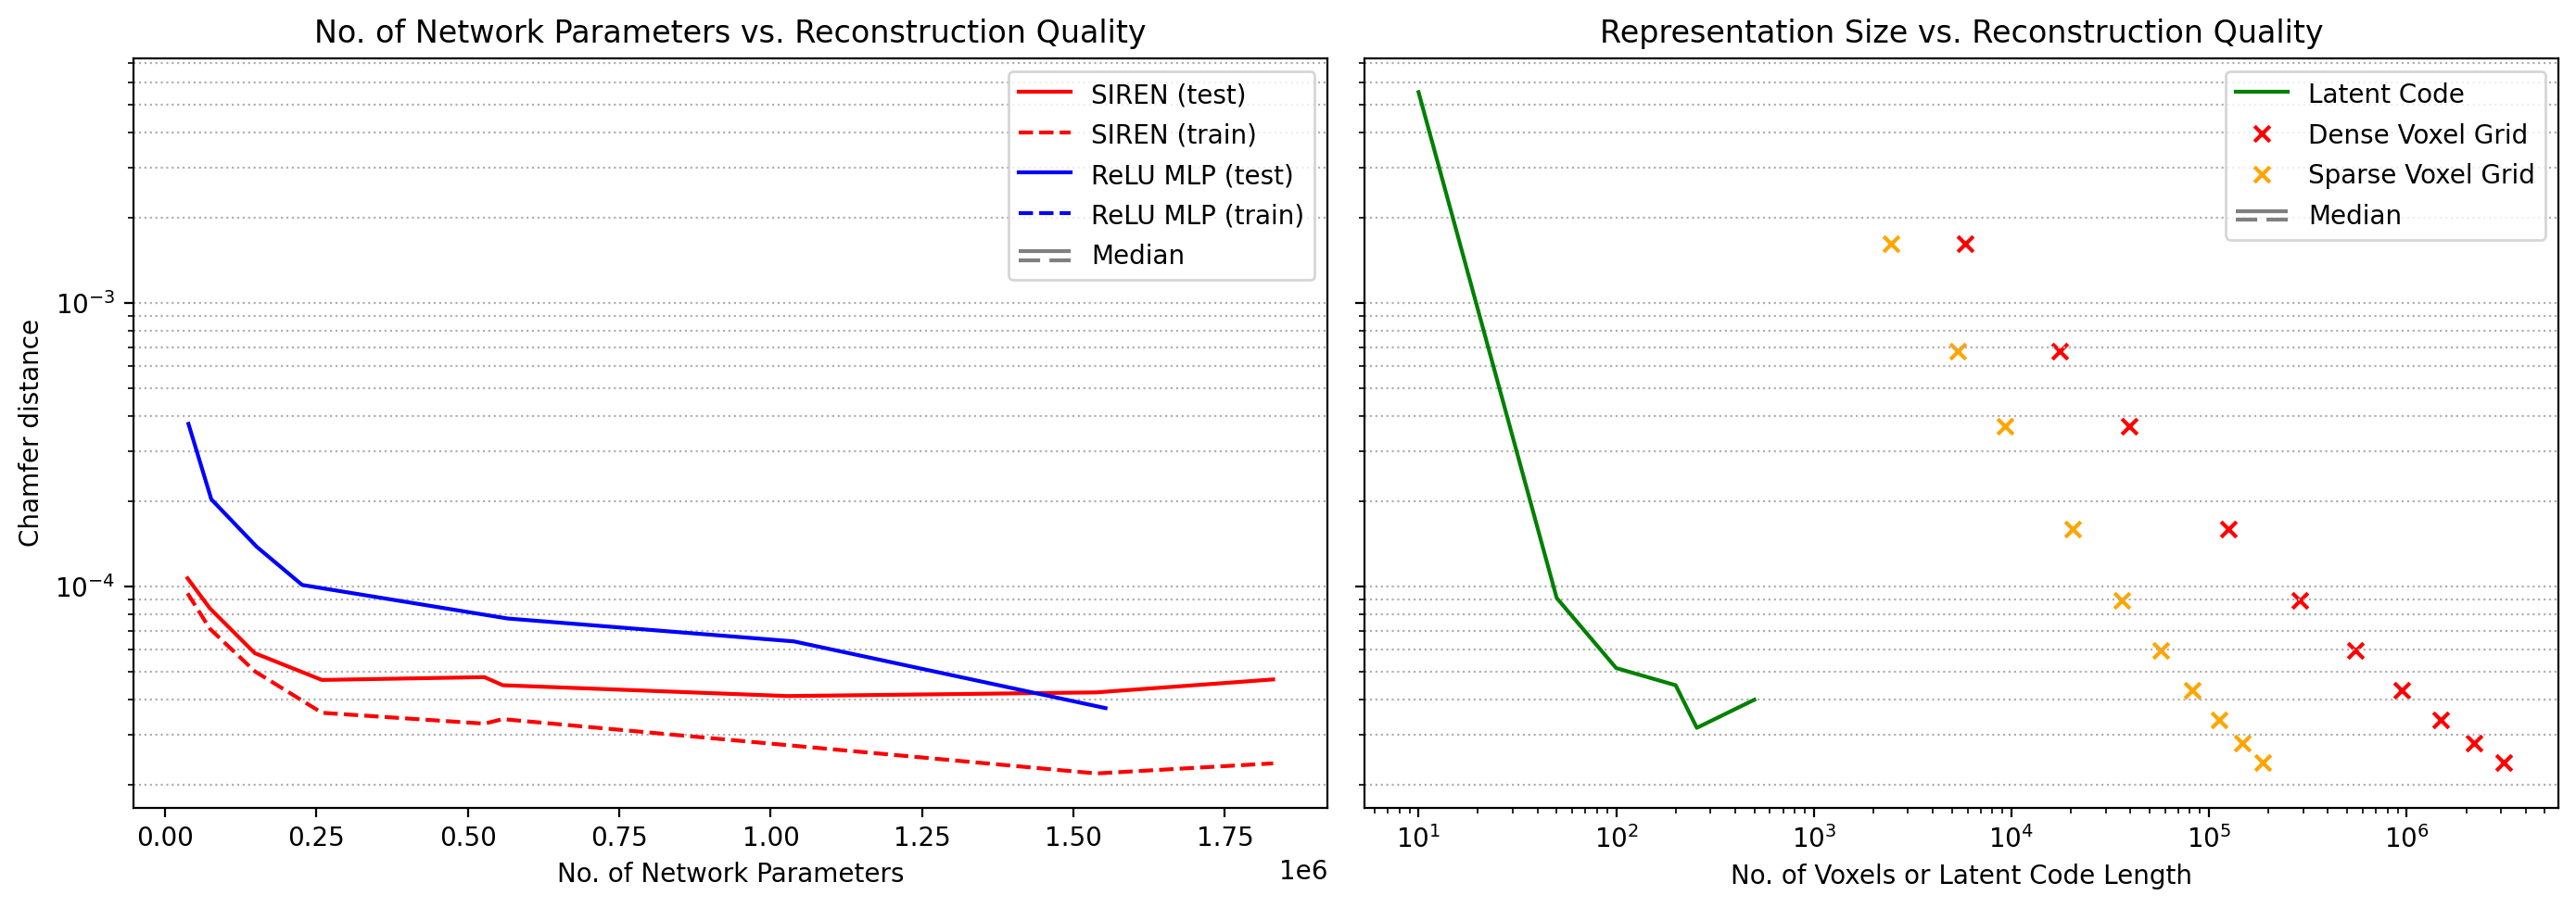

In [18]:
exps_net = [
    "../../shared/deepsdfcomp/searches/num_params_search/exp00_3layers_96width",    
    "../../shared/deepsdfcomp/searches/num_params_search/exp00_4layers_128width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp01_6layers_192width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp02_8layers_256width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp04_12layers_384width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp04.2_4layers_192width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp05_6layers_288width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp06_8layers_384width",
    # "../../shared/deepsdfcomp/searches/num_params_search/exp08_6layers_384width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp09_8layers_512width",
]
exps_net_relu = [
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp00_3layers_96width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp00_4layers_128width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp01_6layers_192width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp02_8layers_256width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp04_12layers_384width_relu",  
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp04.2_4layers_192width_relu",  
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp06_8layers_384width_relu",  
    ]
exps_lat = [
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_10",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_50",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_100",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_200",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_256",
    # "../../shared/deepsdfcomp/searches/num_latents_search/exp_300",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_500",
]
vox_logs = [
    "data/voxelize_sdf_gen/vox_res=16/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=32/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=24/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=48/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=64/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=80/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=96/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=112/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=128/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=144/run_voxelize_logs.csv",
    # "data/voxelize_sdf_gen/vox_res=160/run_voxelize_logs.csv",
    # "data/voxelize_sdf_gen/vox_res=176/run_voxelize_logs.csv",
]
plotting.plot_capacity_vs_chamfer_dist(
    exp_dirs_net_capacity = exps_net, 
    exp_dirs_net_relu_capacity = exps_net_relu,
    exp_dirs_lat_capacity = exps_lat, 
    voxelization_logs= vox_logs,
    plot_aspect_ratios = False,
    plot_means = False,
)

In [93]:
p = "/mnt/hdd/ShapeNetCore.v2/02691156/d5b08d1355502d325f83a2299c09f64/models/model_normalized.obj"
p = "../../shared/deepsdfcomp/data/manifold_meshes/02691156/d5b08d1355502d325f83a2299c09f64.obj"
p = "/home/wulff/deepsdf/TESTmodel_watertight1.obj"
p = "/home/wulff/deepsdf/quadriflow.obj"
p = "/home/freissmuth/deepsdf/suzan.obj"
p = "/home/shared/deepsdfcomp/data/quadriflow_meshes/02691156/d0456644386d9149ce593c35f70d3f.obj"
p = "/home/shared/deepsdfcomp/data/quadriflow_meshes/02691156/d1119217281b8475fe755e3418b63110.obj"
p = "/mnt/hdd/ShapeNetCore.v2/02691156/d5b08d1355502d325f83a2299c09f64/models/model_normalized.obj"

mesh = utils.scale_to_unit_cube(utils.as_mesh(trimesh.load(p)))
voxels = mesh_to_sdf.mesh_to_voxels(mesh, 64, pad=True, sign_method="depth", check_result=False)
verts, faces, normals, _ = skimage.measure.marching_cubes(voxels, level=0.01, method="lewiner", spacing=[2.0 / (64 - 1)] * 3, )
recon = utils.scale_to_unit_cube(trimesh.Trimesh(verts, faces, vertex_normals=normals))
recon.show()

In [31]:
highres_dim = 64
lowres_dim = 9
padding_lowres = 0
padding_highres = math.ceil(highres_dim / lowres_dim) * padding_lowres
highres_voxel_size = 1 / (highres_dim - 2 * padding_highres)
lowres_voxel_size = 1 / (lowres_dim - 2 * padding_lowres)


dx

0.038461538461538464

In [102]:
# p = "/mnt/hdd/ShapeNetCore.v2/02691156/1a6ad7a24bb89733f412783097373bdc/models/test.npy"
# sdf_voxel_grid = np.load(p)

padding = 3
vox_res = 64

voxel_dict = mesh.get_SDFGen_voxels("1a04e3eab45ca15dd86060f189eb133", vox_res, padding)
recon = mesh.get_mesh_from_SDFGen_voxels(voxel_dict["voxels"], voxel_dict["voxel_size"], voxel_dict["centroid"], voxel_dict["scale"])


# print(sdf_voxel_grid.shape)
# # 0.005 works
# # 0.008
# dx_ = 2.0 / (vox_res - padding)
# verts, faces, normals, _ = skimage.measure.marching_cubes(sdf_voxel_grid, level=voxel_dict["voxel_size"]/2, method="lewiner")#, spacing=[dx_] * 3, )
# recon = trimesh.Trimesh(verts, faces, vertex_normals=normals)
# recon = utils.scale_to_unit_cube(recon)
# recon = utils.rescale_unit_mesh(recon, shift=voxel_dict["centroid"], scale=voxel_dict["scale"])
# print(recon.bounding_box.vertices)


recon.show()

Reading data.
Read in 1250 vertices and 4688 faces.
Bound box size: (-1.10345 -1.10345 -1.10345) to (1.10345 1.10345 1.10345) with dimensions 64 64 64.
Computing signed distance field.
Writing results to: /mnt/hdd/ShapeNetCore.v2/02691156/1a04e3eab45ca15dd86060f189eb133/models/normalized_unit.vti
Writing df results to: /mnt/hdd/ShapeNetCore.v2/02691156/1a04e3eab45ca15dd86060f189eb133/models/normalized.npy
Writing if results to: /mnt/hdd/ShapeNetCore.v2/02691156/1a04e3eab45ca15dd86060f189eb133/models/normalized_if.npy
Processing complete.


In [87]:
recon.centroid, gt.centroid

(array([-0.08139312, -0.03406555,  0.11141083]),
 array([-0.00241143, -0.01396539,  0.02305368]))

In [75]:
gt.show()

In [5]:
gt = utils.as_mesh(trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/d3b9114df1d8a3388e415c6cf89025f0/models/model_normalized.obj"))
recon = utils.as_mesh(trimesh.load("/home/wulff/deepsdf/data/voxelize_sdf_gen_test/vox_res=16/02691156/d3b9114df1d8a3388e415c6cf89025f0.ply"))

objs = [gt, recon]
# objs = [gt]
# objs = [recon]
scene = trimesh.Scene(objs)
scene.show()

In [152]:
mesh = trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/d068bfa97f8407e423fc69eefd95e6d3/models/model_normalized.obj")
mesh = trimesh.load("../../shared/deepsdfcomp/data/manifold_meshes/02691156/d068bfa97f8407e423fc69eefd95e6d3.obj")

mesh = utils.as_mesh(mesh)
L = trimesh.smoothing.laplacian_calculation(mesh)
L_ = L.tocsr()
# Get the per-vertex Laplacian value
all_vertex_values = []
# Loop through all vertices and their (varying number of) neighbor vertices.
for i, js in enumerate(mesh.vertex_neighbors):
    # Get the Laplacian weights of the [i,j1], [i,j2], ... cells.
    v_vals = L_[i, js]
    all_vertex_values.append(v_vals.mean())
all_vertex_values = np.array(all_vertex_values)
# Aggregate per-vertex values to per-face values.
v0 = all_vertex_values[mesh.faces[:, 0]]
v1 = all_vertex_values[mesh.faces[:, 1]]
v2 = all_vertex_values[mesh.faces[:, 2]]
all_faces_values = np.mean([v0, v1, v2], axis=0)

# Produce face colors from face values and colormap.
cmap_low_to_high = matplotlib.colormaps["plasma"].colors
# Convert to RGBA and scale to [0, 255].
cmap_low_to_high = [[int(_*255) for _ in color] + [255] for color in cmap_low_to_high]
face_colors = list(map(lambda v: cmap_low_to_high[int(v*len(cmap_low_to_high))], all_faces_values))
# RGBA in range [0, 255]. Default is [102, 102, 102, 255].
mesh.visual.face_colors = np.array(face_colors)/255

from scipy import stats
print(stats.describe(all_faces_values))

In [77]:
face_curvatures.shape

(32600, 3)

In [86]:
import trimesh
import numpy as np
import scipy
import igl
import robust_laplacian
# mesh = trimesh.load("/home/freissmuth/deepsdf/suzan.obj")
mesh = trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/10155655850468db78d106ce0a280f87/models/model_normalized.obj")
if type(mesh) == trimesh.scene.scene.Scene:
    mesh = trimesh.util.concatenate(mesh.dump())

l, m = robust_laplacian.mesh_laplacian(np.array(mesh.vertices), np.array(mesh.faces))
minv = scipy.sparse.diags(1 / m.diagonal())
Lap = -minv.dot(l)
curvatures = np.linalg.norm(Lap.dot(mesh.vertices), axis=1)
curvatures = np.clip(curvatures, np.percentile(curvatures, 0.00), np.percentile(curvatures, 50))

mesh.visual.vertex_colors = trimesh.visual.interpolate(curvatures, color_map='viridis')
trimesh.Scene(mesh).show()

face_curvatures = curvatures[mesh.faces].mean(axis=1)
face_areas = trimesh.triangles.area(mesh.triangles)
face_curvatures = np.interp(face_curvatures,
                            (face_curvatures.min(), face_curvatures.max()),
                            (0, 1))
face_areas = np.interp(face_areas,
                       (face_areas.min(), face_areas.max()),
                       (0, 1))
weights = 0.5 * (face_curvatures + face_areas)

concatenating texture: may result in visual artifacts


In [156]:
from scipy import stats

stats.describe(all_faces_values)
stats.describe(face_colors)

/tmp/ipykernel_77725/41908331.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.describe(face_colors)
/home/wulff/anaconda3/envs/deep3dcomp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1522: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/home/wulff/anaconda3/envs/deep3dcomp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)


DescribeResult(nobs=204106, minmax=(array([ 54,   0, 128, 255]), array([194,  61, 168, 255])), mean=array([ 92.10344625,   0.47199004, 164.79521425, 255.        ]), variance=array([70.12444495,  0.47144542,  3.75323664,  0.        ]), skewness=array([-0.11646877, 11.01858125, -0.82383447,         nan]), kurtosis=array([1.27173278e-01, 8.87439603e+02, 2.35515274e+00,            nan]))

In [ ]:
mesh.show()

In [93]:
faces_v

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [75]:
a[0].shape

(3, 275)

In [4]:
from pytorch3d.structures import Meshes
from pytorch3d import structures, io, loss

filename = "/mnt/hdd/ShapeNetCore.v2/02691156/fef1c15a5db21b00a67cc8f661e7890a/models/model_normalized.obj"
mesh = utils.as_mesh(trimesh.load(filename))

# verts, faces = io.load_ply(filename)
# verts, faces, aux = io.load_obj(filename)
# meshes = Meshes(verts=[verts], faces=[faces.verts_idx])

meshes = trimesh_to_pytorch3d_meshes(mesh)
loss.mesh_normal_consistency(meshes)

tensor(0.7256)

In [13]:
filename = "../../shared/deepsdfcomp/searches/double_nonlinearity/baseline/Reconstructions/2000/Meshes/ShapeNetV2/02691156/d0456644386d9149ce593c35f70d3f.ply"
mesh = utils.as_mesh(trimesh.load(filename))
meshes = utils.trimesh_to_pytorch3d_meshes([mesh])
loss.mesh_normal_consistency(meshes)

tensor(0.0228)

In [11]:
meshes.faces_list()

[tensor([[    2,     1,     0],
         [    4,     3,     0],
         [    4,     0,     1],
         ...,
         [45684, 45682, 45683],
         [45684, 45683, 45685],
         [45685, 45683, 45680]]),
 tensor([[    2,     1,     0],
         [    4,     3,     0],
         [    4,     0,     1],
         ...,
         [45684, 45682, 45683],
         [45684, 45683, 45685],
         [45685, 45683, 45680]])]

In [64]:
filename = "../../shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Reconstructions/2000/Meshes/ShapeNetV2/02691156/d0456644386d9149ce593c35f70d3f.ply"
mesh = utils.as_mesh(trimesh.load(filename))
meshes = trimesh_to_pytorch3d_meshes(mesh)
loss.mesh_normal_consistency(meshes)

tensor(0.0197)

In [21]:
torch.Tensor(np.array(mesh.faces)).size(2)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
experiment_dirs = [
    "../../shared/deepsdfcomp/searches/double_nonlinearity/baseline",
    # "../../shared/deepsdfcomp/searches/double_nonlinearity/all_latentsize=200_width=256_lr=5e-4_int=150",
    "../../shared/deepsdfcomp/searches/double_nonlinearity/line",
    "../../shared/deepsdfcomp/searches/double_nonlinearity/plane",
    "../../shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule",
]

shape_ids = [
    "fc16704314dc71ee9a6e43b878d5b335",
    "f6e6fd724a9eab24ba8e93696257b3fc",  
    "fef1c15a5db21b00a67cc8f661e7890a",
    "df25be12ae47d2517ef7776b3bf5815c",
    "f9db62e6a88f0d7129343faf3bbffb15",
]

plotting.plot_reconstruction_comparison(experiment_dirs, shape_ids)

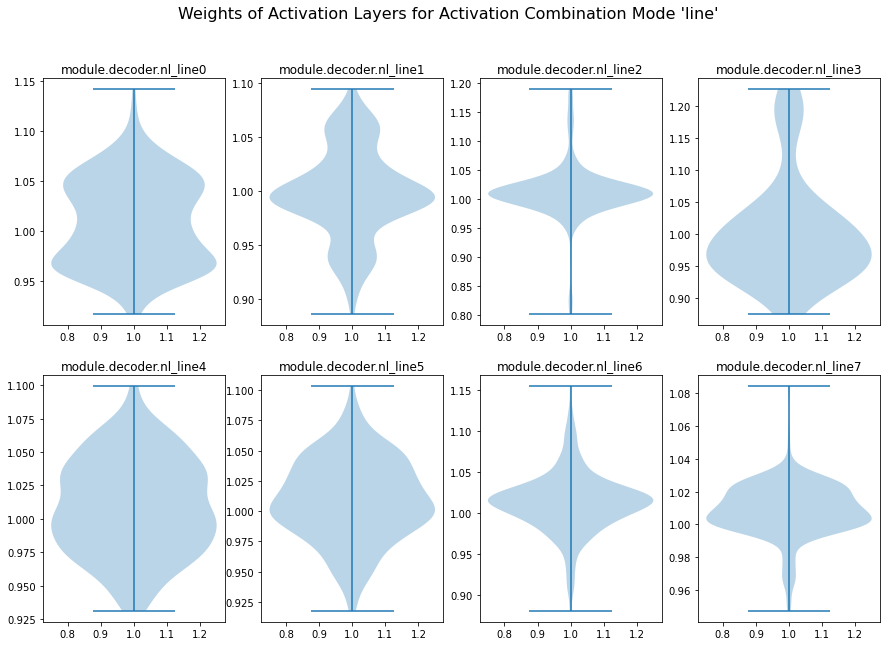

In [32]:
import torch
from matplotlib import pyplot as plt
chckpt = torch.load("/home/shared/deepsdfcomp/searches/double_nonlinearity/line/ModelParameters/latest.pth")
fig, axes = plt.subplots(2, 4, figsize=(15,10))
fig.suptitle("Weights of Activation Layers for Activation Combination Mode 'line'", fontsize=16)
for i, (k,v) in enumerate([(kk, vv) for kk, vv in chckpt["model_state_dict"].items() if "nl_line" in kk][:8]):
    ax = axes[i//4,i%4]
    ax.set_title(k)
    vplot = ax.violinplot(v.detach().cpu().numpy(), showmeans=False, showextrema=True)
plt.show()

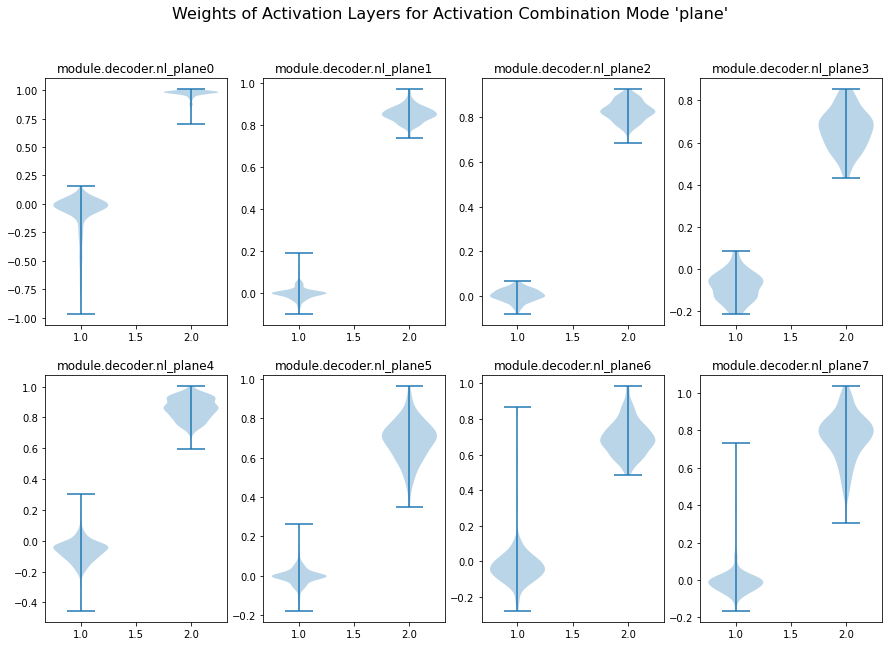

In [39]:
import torch
from matplotlib import pyplot as plt
chckpt = torch.load("/home/shared/deepsdfcomp/searches/double_nonlinearity/plane/ModelParameters/latest.pth")
fig, axes = plt.subplots(2, 4, figsize=(15,10))
fig.suptitle("Weights of Activation Layers for Activation Combination Mode 'plane'", fontsize=16)
for i, (k,v) in enumerate([(kk, vv) for kk, vv in chckpt["model_state_dict"].items() if "nl_plane" in kk][:8]):
    ax = axes[i//4,i%4]
    ax.set_title(k)
    vplot = ax.violinplot(v.detach().cpu().numpy(), showmeans=False, showextrema=True)
plt.show()

In [4]:
import pandas as pd
data = pd.read_csv("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer.csv", delimiter=';')
print(f"{data['chamfer_dist'].mean():5f}, {data['chamfer_dist'].median():5f}")

0.083380, 0.083885


In [ ]:
python reconstruct.py  --split ../../shared/deepsdfcomp/experiments/splits/sv2_planes_test.json -d ../../shared/deepsdfcomp/data/ -e ../../shared/deepsdfcomp/searches/double_nonlinearity/line --skip
python evaluate.py  --split ../../shared/deepsdfcomp/experiments/splits/sv2_planes_test.json -d ../../shared/deepsdfcomp/data/ -e ../../shared/deepsdfcomp/searches/double_nonlinearity/line -c 2000

9

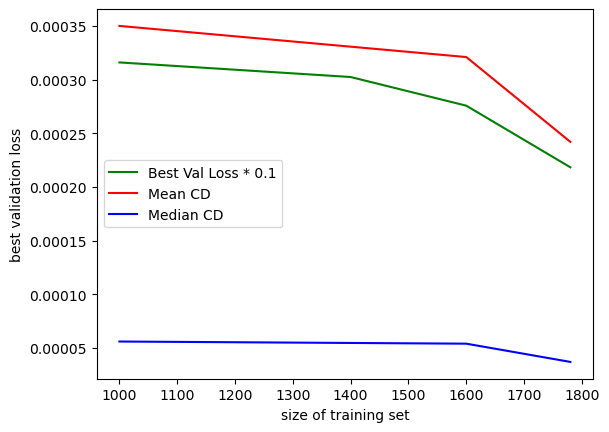

In [20]:
import numpy as np
from matplotlib import pyplot as plt
set_sizes = np.array([1780, 1600, 1400, 1200, 1000, 600, 200])
val_losses = np.array([2.183e-3, 2.757e-3, 3.024e-3, np.nan, 3.16e-3, np.nan, np.nan])
mean_CDs = np.array([0.242e-3, 0.321e-3, np.nan, np.nan, 0.350e-3, np.nan, np.nan])
median_CDs = np.array([0.037e-3, 0.054e-3, np.nan, np.nan, 0.056e-3, np.nan, np.nan])

plt.plot(set_sizes[np.isfinite(val_losses)], val_losses[np.isfinite(val_losses)]*0.1, 'g', label="Best Val Loss * 0.1")
plt.plot(set_sizes[np.isfinite(mean_CDs)], mean_CDs[np.isfinite(mean_CDs)], 'r', label="Mean CD")
plt.plot(set_sizes[np.isfinite(median_CDs)], median_CDs[np.isfinite(median_CDs)], 'b', label="Median CD")
plt.xlabel("size of training set")
plt.ylabel("best validation loss")
plt.legend()

In [21]:
import json
import random
import copy
import os
path = "/home/shared/deepsdfcomp/searches/splits/"
fname = "sv2_planes_train"
with open(os.path.join(path, fname + ".json"), 'r') as f:
    all_shapes_dict = json.load(f)
split_sizes = [1780, 1600, 1400, 1200, 1000, 800, 600, 400, 200]
for split_size in split_sizes:
    split = copy.deepcopy(all_shapes_dict)
    sampled_list = random.shuffle(split["ShapeNetV2"]["02691156"])
    split["ShapeNetV2"]["02691156"] = split["ShapeNetV2"]["02691156"][:split_size]
    with open(os.path.join(path, "subsamples", f"{fname} _{split_size}.json"), 'w+') as f:
        json.dump(split, f, indent=4)

"baseline"
	Curvature Sampling: 0 % 
	Mean CD: 1.467e-04
	Median CD: 4.003e-05
	Best Meshes:
		fdcb11fa39661f0fb08f81d66e854bfa with CD of 1.1679990103997374e-06
		df411aa240fe48d5855eb7906a7a7a04 with CD of 1.6090262747775775e-06
		d28a3cd771b2bf1e71d03b466c72ce41 with CD of 8.657810973807102e-06
	Worst Meshes:
		e3f562bd552fbb14496e2f80fb255499 with CD of 0.0101094990308915
		fc16704314dc71ee9a6e43b878d5b335 with CD of 0.00358775584537
		d8a037897d5d5b108130971b27e95927 with CD of 0.0029784317984686
"siren_w256"
	Curvature Sampling: 0 % 
	Mean CD: 1.786e-04
	Median CD: 3.215e-05
	Best Meshes:
		fdcb11fa39661f0fb08f81d66e854bfa with CD of 9.942681180843752e-07
		df411aa240fe48d5855eb7906a7a7a04 with CD of 2.100116248861366e-06
		df1c68e94259c6cf5c7319b71bdce6e with CD of 7.015171780932786e-06
	Worst Meshes:
		fc16704314dc71ee9a6e43b878d5b335 with CD of 0.0087567936615533
		f6e6fd724a9eab24ba8e93696257b3fc with CD of 0.0053444610768455
		fef1c15a5db21b00a67cc8f661e7890a with CD of 0.00

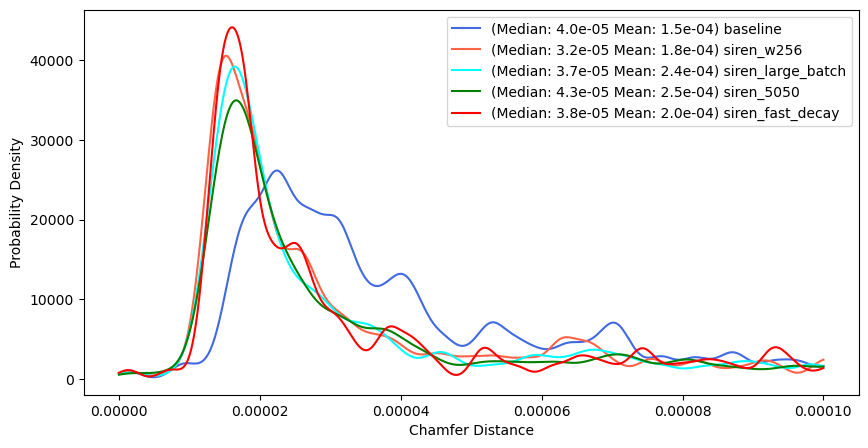

In [6]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
experiments = [
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer.csv", "baseline", "royalblue"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.200.csv", "baseline", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.300.csv", "baseline", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.500.csv", "baseline", "cyan"),
                # ("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_1.000.csv", "baseline", "lightskyblue"),
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer.csv", "siren_w256", "tomato"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.200.csv", "siren_w256", "cyan"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.300.csv", "siren_w256", "cyan"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.500.csv", "siren_w256", "cyan"), # best
                # ("/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_1.000.csv", "siren_w256", "lightsalmon"), # best
                ( "/home/shared/deepsdfcomp/searches/num_shapes_search/all_shapes_batch_size_128/Evaluation/2000/chamfer.csv", "siren_large_batch", "cyan"),
                ( "/home/shared/deepsdfcomp/searches/double_nonlinearity/line_5050_ini/Evaluation/2000/chamfer.csv", "siren_5050", "green"),
                ( "/home/shared/deepsdfcomp/searches/double_nonlinearity/all_latentsize=200_width=256_lr=5e-4_int=150/Evaluation/2000/chamfer.csv", "siren_fast_decay", "red"),
            ]

plt.figure(figsize=(10,5))
for csv_path, exp_name, color in experiments:
    CDs = pd.read_csv(csv_path, sep=";")
    # plt.hist(CDs, np.linspace(0, 0.002, 2000), alpha=1/len(csv_paths), label=csv_path.split("/")[-1])
    
    median = CDs["chamfer_dist"].median()
    mean = CDs["chamfer_dist"].mean()
    density = gaussian_kde(CDs["chamfer_dist"])
    density.covariance_factor = lambda : .003
    density._compute_covariance()
    x = np.linspace(0, 0.0001, 500)
    densities = density(x)
    
    # find best and worst meshes
    n = 3
    best_df= CDs.nsmallest(n, columns=["chamfer_dist"])
    worst_df= CDs.nlargest(n, columns=["chamfer_dist"])
    best_meshes = [mesh.split("/")[-1] for mesh in list(best_df["shape"])]
    best_mesh_cds = list(best_df["chamfer_dist"])
    worst_meshes = [mesh.split("/")[-1] for mesh in list(worst_df["shape"])]
    worst_mesh_cds = list(worst_df["chamfer_dist"])
    
    
    curvature = "0.000" if "chamfer_" not in csv_path else csv_path.split("_")[-1].split(".csv")[0]
    plt.plot(x, densities, label=f"(Median: {median:.1e} Mean: {mean:.1e}) {exp_name}", color=color)
    print(f'"{exp_name}"')
    print(f"\tCurvature Sampling: {int(float(curvature) * 100)} % ")
    print(f"\tMean CD: {np.mean(CDs['chamfer_dist']):.3e}")
    print(f"\tMedian CD: {np.median(CDs['chamfer_dist']):.3e}")
    print(f"\tBest Meshes:")
    for bm, cd in zip(best_meshes, best_mesh_cds):
        print(f"\t\t{bm} with CD of {cd}")
    print(f"\tWorst Meshes:")
    for wm, cd in zip(worst_meshes, worst_mesh_cds):
        print(f"\t\t{wm} with CD of {cd}")
plt.legend()
_ = plt.xlabel("Chamfer Distance")
_ = plt.ylabel("Probability Density")


In [1]:
import trimesh
import os
import json
mesh_name = "d3b9114df1d8a3388e415c6cf89025f0"
mesh = trimesh.load(os.path.join("/mnt/hdd/ShapeNetCore.v2/02691156", mesh_name, "models/model_normalized.obj"))
with open(os.path.join("/mnt/hdd/ShapeNetCore.v2/02691156", mesh_name, "models/model_normalized.json"), 'r') as f:
    properties = json.load(f)
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(mesh.dump())
print(mesh.vertices.min(axis=0), mesh.vertices.max(axis=0))

surface_samples = trimesh.load(os.path.join("/home/shared/deepsdfcomp/data/SurfaceSamples/ShapeNetV2/02691156", mesh_name + ".ply"))
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(surface_samples.dump())
print(surface_samples.vertices.min(axis=0), surface_samples.vertices.max(axis=0))

reco = trimesh.load(os.path.join("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Reconstructions/2000/Meshes/ShapeNetV2/02691156", mesh_name + ".ply"))
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(reco.dump())
print(reco.vertices.min(axis=0), reco.vertices.max(axis=0))


# samples = np.load()
# samples = samples[samples.files[0]]
# print(samples.min(axis=0), samples.max(axis=0)) 

concatenating texture: may result in visual artifacts


[-0.285115 -0.075618 -0.36779 ] [0.285099 0.19598  0.40751 ]
[-0.285115   -0.0755929  -0.36055401] [0.285099   0.19592801 0.40506601]
[-0.68753284 -0.31896016 -0.7864542 ] [0.68319559 0.30436653 0.88733315]


'pos'